In [1]:
# Imports (numpy, pandas, matplotlib, seaborn imported automatically)
import requests
from etherscan import Etherscan
from BondingCurveNexus import config
from scipy.stats import poisson, lognorm, norm
from random import shuffle

In [2]:
# activate etherscan client
eth_client = Etherscan(config.etherscan_api)

eth_client.get_eth_last_price()

{'ethbtc': '0.06835',
 'ethbtc_timestamp': '1652801803',
 'ethusd': '2061.47',
 'ethusd_timestamp': '1652801802'}

# Nexus Tokenomics Investigation

## Set-up & Parameters

In [3]:
nxm_supply = 6_881_387
act_cover = 176_623
capital_factor = 4.8
mcr_floor = 162_425
cap_pool = 155_772

def mcr():
    return max(mcr_floor, act_cover/capital_factor)

def mcrp():
    return cap_pool/mcr()

def book_value():
    return cap_pool/nxm_supply

print(f'mcrp: {mcrp()}, book value: {book_value()}')

mcrp: 0.9590395567184855, book value: 0.022636715534237503


### Current & historic wNXM price feed

In [9]:
url = 'https://api.coingecko.com/api/v3/simple/price'
params = {
        'ids':'wrapped-nxm',
        'vs_currencies': 'eth'
        }
wnxm_price = requests.get(url, params=params).json()['wrapped-nxm']['eth']
wnxm_price

0.00925029

In [10]:
hist_url = 'https://api.coingecko.com/api/v3/coins/wrapped-nxm/market_chart'
hist_params = {
        'id':'wrapped-nxm',
        'vs_currency': 'eth',
        'days': 'max'
        }
historic_wnxm_price = requests.get(hist_url, params=hist_params).json()

### Historic wNXM parameters

In [11]:
wNXM_history = pd.DataFrame(historic_wnxm_price['prices'])
wNXM_history.columns = ['block', 'ETH_price']

In [12]:
wNXM_history['change_vs_ETH'] = wNXM_history['ETH_price']/wNXM_history['ETH_price'].shift(1) - 1

In [13]:
wNXM_history[['change_vs_ETH']].describe()

,change_vs_ETH
count,660.000000
mean,0.000099
std,0.065491
min,-0.236422
25%,-0.028485
50%,-0.007047
75%,0.017383
max,0.579456


## Old Model (for reference)

In [5]:
a = 0.01028
c = 5_800_000
token_price = a + (mcr()/c)*(mcrp()**4)
token_price

0.03397032201497094

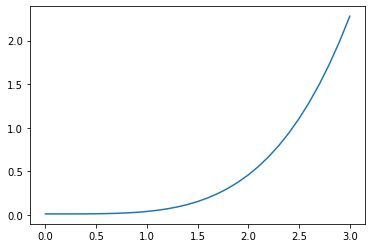

In [8]:
perc_range = np.linspace(0, 3, 31)

token_price_range = a + (mcr()/c)*(perc_range**4)
plt.plot(perc_range, token_price_range);

## New Version - Capital Entry

### Bond Bonus Formula

In [14]:
# creating shape of discount vs. mcr_perc below 100%
def bond_bonus(mcr_perc):
    return 0.2 * (1 - np.exp(-30 * (1-mcr_perc)))

MCR% at 0.0:          Biweekly interest at 20.0%,          Annual interest at 11347.55%
MCR% at 0.01:          Biweekly interest at 20.0%,          Annual interest at 11347.55%
MCR% at 0.02:          Biweekly interest at 20.0%,          Annual interest at 11347.55%
MCR% at 0.03:          Biweekly interest at 20.0%,          Annual interest at 11347.55%
MCR% at 0.04:          Biweekly interest at 20.0%,          Annual interest at 11347.55%
MCR% at 0.05:          Biweekly interest at 20.0%,          Annual interest at 11347.55%
MCR% at 0.06:          Biweekly interest at 20.0%,          Annual interest at 11347.55%
MCR% at 0.07:          Biweekly interest at 20.0%,          Annual interest at 11347.55%
MCR% at 0.08:          Biweekly interest at 20.0%,          Annual interest at 11347.55%
MCR% at 0.09:          Biweekly interest at 20.0%,          Annual interest at 11347.55%
MCR% at 0.1:          Biweekly interest at 20.0%,          Annual interest at 11347.55%
MCR% at 0.11:          

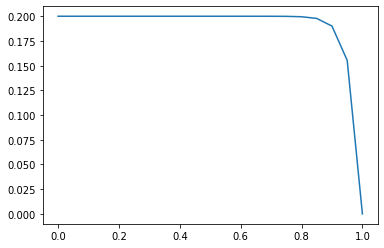

In [15]:
perc_range_below_100 = np.linspace(0, 1, 21)
bond_bonus_range = bond_bonus(perc_range_below_100)
for i in np.linspace(0, 1, 101):
    print(f'MCR% at {round(i, 2)}:\
          Biweekly interest at {round(bond_bonus(i)*100, 2)}%,\
          Annual interest at {round(((1+bond_bonus(i))**26 - 1)*100, 2)}%')
plt.plot(perc_range_below_100, bond_bonus_range);

### Mechanism for Single Entry with Bond

In [64]:
# creates the linear vesting LP token that can be redeemed for NXM as a numpy row vector.
# Will only apply when MCR < 1, otherwise instantaneous exchange of ETH for NXM at wNXM price

# length of simulation
model_days = 365
bond_length = 14
current_day = 0

def single_bond(eth):
    # create array of zeros representing whole modelling period
    row_vec = np.zeros(model_days + bond_length)
    
    # what could someone get now at highest of wnxm price or book value
    nxm_now = eth/max(wnxm_price, book_value())
    
    # create array of entry-size NXM possibilities over 14 days (and cap at book value)
    nxm_obtained_array = np.linspace(nxm_now, nxm_now*(1+bond_bonus(mcrp())), bond_length+1)
    nxm_obtained_array[eth/nxm_obtained_array < book_value()] = eth/book_value()
    
    # pick at which point the user will claim their tokens - simplification
    actual_entry_delay = np.random.randint(bond_length + 1)
    
    # replace the relevant time period in question in the array of zeros with the entry NXM obtained
    row_vec[current_day + actual_entry_delay] = nxm_obtained_array[actual_entry_delay]

    return row_vec

In [59]:
nxm_now = 2/max(wnxm_price, book_value())
entry_array = np.linspace(nxm_now, nxm_now*(1+bond_bonus(mcrp())), bond_length+1)
entry_array[2/entry_array < book_value()] = 2/book_value()

In [63]:
2/book_value()

88.35204016126133

In [ ]:
entry_array 

## New Version - Capital Exit

### Weighted average days on covers 

In [ ]:
### TODO: Provide live feed instead of just pulling in .csv
# https://github.com/rchen8/nexus-mutual-tracker

Treat Weighted Average Days of cover expiry as fixed - unlikely to be able to calculate this on-chain

In [21]:
# bring in csv
active_covers_expiration = pd.read_csv('../raw_data/active_cover_amount_by_expiration_date.csv')
# rename columns
active_covers_expiration.columns = ['exp_time', 'USD', 'ETH']
# convert expiry time from string to datetime
active_covers_expiration['exp_time'] = pd.to_datetime(active_covers_expiration['exp_time'])
# create a 'days remaining column by subtracting today's date in datetime format
active_covers_expiration['days_remaining'] = active_covers_expiration['exp_time']-pd.Timestamp.now().normalize()
# create an integer minutes remaining column by dividing by a timedelta minute object
active_covers_expiration['minutes_remaining'] = active_covers_expiration['days_remaining']/np.timedelta64(1, 'm')

#calculate weighted average minutes remaining based on cover amount
wavg_minutes = ((active_covers_expiration['ETH']*active_covers_expiration['minutes_remaining'])
                /active_covers_expiration['ETH'].sum()).sum()

# calculate 
wavg_days = wavg_minutes/(24*60)
wavg_days

62.74942228568537

In [32]:
2*wavg_days

125.49884457137074

### Mechanism for Single Exit

In [25]:
def exit_ratio(days_selected):
    amp_factor = 2
    amp_days = amp_factor * wavg_days
    return min(1, days_selected/amp_days)**2

In [33]:
model_days = 365
current_day = 0
ratio_burned = 0.1

# single_delayed_exit returns a row vector of model_days*2.
# Modelling will likely last a year, so people wishing to exit for a full year at the end of the modelling
# require another year to model into future
# only relevant for mcrp <= 1, otherwise there is an instant exit at book value
def single_delayed_exit(days_selected, eth):
    # calculate amount of nxm that user wants to sell from eth they want to obtain
    nxm_now = eth/book_value()
    
    # create empty row vector
    row_vec = np.zeros(model_days*2)
    
    # give user option of exiting over 30 days after their exit ratio period expires
    row_vec[current_day + days_selected - 1:current_day + days_selected + 30] = nxm_now * exit_ratio(days_selected)
    return row_vec

### Dynamic Current Assets

DCA = Size of capital pool X-days in the future, i.e. current Capital Pool minus everything in the Exit Queue

In [30]:
# create function that calculates the size of the exit queue  
def exit_queue_size():
    return np.sum(exit_array[:, current_day:])

### Account for Different Exit Scenarios

## Nexus System Development

Every day, the following happens:

- Users **enter** the system by buying NXM from the mutual **at wNXM price** (or with some discount)
    - expect this number to be higher when mcrp < 1 because there is a discount to wNXM depending on vesting period
    - some will want to buy wNXM for ease, some will want to buy NXM for use on the platform
- Users **exit** from the system **at book value**
    - noone if wNXM price > book value, as first, NXM would be converted to wNXM and sold on the open market. This will drive the price down to book value if more users want to exit.
    - If wNXM price <= book value, expect wNXM buys and exits through book value, driving wNXM price up to book value (with a slight time value discount, assume 5% per year)
- Change in wNXM price
    - if below book value, price gets driven up towards *book value less time discount*
    - if above book value, could go up if mutual doing well, could go down if mutual perceived to be doing badly (e.g. after a big claim)
- Funds come in to capital pool separately through premiums & investment
    - steady stream of income from premiums, possibly increasing, test decrease as well
    - steady stream of income from investments, say 5% on 30% of capital pool to reflect current position
- Funds exit the capital pool through claims
    - rare, but large events
    - possible hits to wNXM price if above book value
- Change in NXM supply
    - entries and exits through capital mechanism (even if NXM created in future)
    - cover buys still create some?
    - some irregular governance rewards
    - burned through cover buys in NXM
    - upon claim, burns of stakers' NXM
- Update active cover amount for tracking mcr requirement
- Update exit queue size
- Update dca & mcrp as a result

In [65]:
# parameters of various developments

# length of simulation
model_days = 365

# ENTERING AND EXITING THE SYSTEM

# assume there are, on average, some same base distribution of entries and exits each day
# modelled by a poisson distribution
lambda_entries = 10
lambda_exits = 10

# lognormal distribution of size of entries & exits in ETH
# parameterised to have  values be small < 1 ETH, the median value to be ~1 ETH,
# upper quartile around 4-5 ETH and the occasional multi-million buy
sale_shape = 2
sale_loc = 0
sale_scale = 1

# COVER AMOUNT

# normal distribution of change in cover amount
cover_amount_mean = 0.0075
cover_amount_stdev = 0.07

# PREMIUM INCOME

# lognormal distribution of daily premium income
# parameterised to have median value of a handful of ETH,
# upper quartile around 10 ETH and the occasional multi-million $ day
premium_shape = 2
premium_loc = 0.02
premium_scale = 3

# CLAIM OCCURENCES

# claim frequency
claim_prob = 0.03

# lognormal distribution of claim size
# parameterised to have values of at least 1 ETH, the median value to be ~9 ETH,
# upper quartile around 30 ETH and the occasional multi-million payout
claim_shape = 2
claim_loc = 1
claim_scale = 8

# WNXM RANDOMNESS

# normal distribution of change in wnxm price, before any adjustments we assume for what happens
wnxm_drift = 0   # assume there's no long-term drift from ETH
wnxm_diffusion = 0.0655 # st.dev. of historic returns since summer 2020

In [69]:
### ---MAIN SIMULATION LOOP--- ###

# set number of base daily entries and exits
daily_entries = poisson.rvs(lambda_entries, size=model_days)
daily_exits = poisson.rvs(lambda_exits, size=model_days)

# start at day 0
current_day = 0

# create empty exit array of ETH liabilities to users and entry array of NXM claims via bonds
exit_array = np.zeros((1, model_days*2))
entry_array = np.zeros((1, model_days+bond_length))

# create tracking for metrics we want to track
mcr_prediction = [mcr()]
cap_pool_prediction = [cap_pool]
mcrp_prediction = [mcrp()]
wnxm_prediction = [wnxm_price]
nxm_supply_prediction = [nxm_supply]
book_value_prediction = [book_value()]

In [36]:
# start looping through days
for i in range(model_days):
    
    # create list of events that happen today and shuffle them to be random
    events_today = []
    events_today.extend(['entry']*daily_entries[i])
    events_today.extend(['exit']*daily_exits[i])
    events_today.extend(['wnxm_shift', 'premium_income', 'claim_check', 'cover_amount_change',
                         'bond_entries', 'delayed_exits'])
    shuffle(events_today)
    
    # loop through the day's events
    for event in events_today:
        if event == 'entry':
            # no entries if wnxm price is below book
            if wnxm_price < book_value():
                continue
            
            # draw entry size from lognormal distribution
            eth_size = lognorm.rvs(s=sale_shape, loc=sale_loc, scale=sale_scale)
            
            # eth enters the capital pool
            cap_pool += eth_size
            
            # NXM Supply changes
            # instantaneous if mcrp >= 1
            if mcrp() >= 1:
                nxm_supply += eth_size / wnxm_price
            # add to queued entry array if mcrp < 1
            else:
                entry_array = np.vstack((entry_array, single_bond(eth_size)))
        
        if event == 'exit':
            # no exits if wnxm price is above book
            if wnxm_price > book_value():
                continue
            
            # draw exit size from lognormal distribution
            eth_size = lognorm.rvs(s=sale_shape, loc=sale_loc, scale=sale_scale)
            
            # 
            if mcrp() >= 1:
                

In [68]:
np.vstack((entry_array, single_bond(2)))
        

array([[ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0. 

In [ ]:
### TEMPORARY RESET CELL ###

nxm_supply = 6_881_387
act_cover = 176_623
capital_factor = 4.8
mcr_floor = 162_425
cap_pool = 155_772

url = 'https://api.coingecko.com/api/v3/simple/price'
params = {
        'ids':'wrapped-nxm',
        'vs_currencies': 'eth'
        }
wnxm_price = requests.get(url, params=params).json()['wrapped-nxm']['eth']
wnxm_price

## Initial Reverse Dutch Auction Mechanism

At launch, exit price = wnxm price

Price slowly increases, but starts dropping down once people try to exit through the mechanism

Keeps going up, stops at book value.

Incentive not to wait longer - some people may end up exiting in front of you and drive down the price.
What if you believe it'll go up eventually anyway...